## Implementation of C4.5 decision tree from Scratch & Classify Iris data - Idriss Khattabi

In [23]:
# import packages
import seaborn as sns 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from math import log
import treePlotter as tpl

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load dataset from seaborn
dataSet = sns.load_dataset('iris')

# dataset infos
print("dataset shape : ", dataSet.shape)
print("iris dataset labels : ", list(dataSet.columns))
dataSet.head()

dataset shape :  (150, 5)
iris dataset labels :  ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


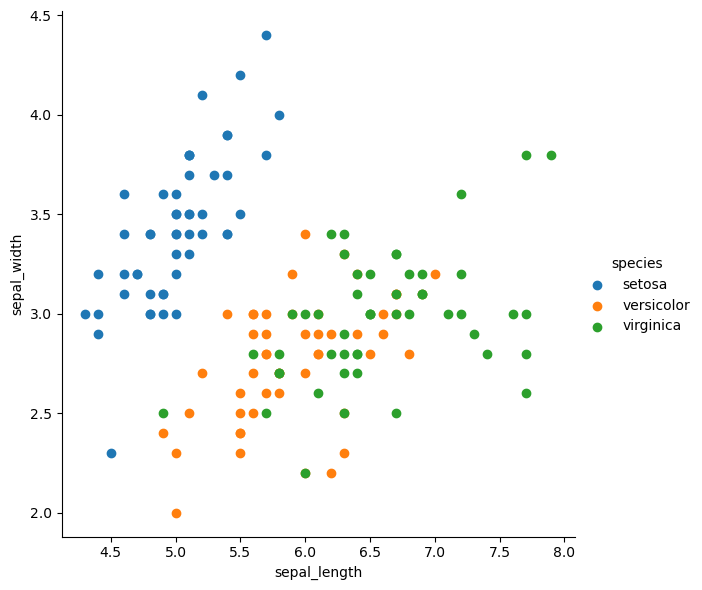

In [192]:
# scatter plot
sns.FacetGrid(dataSet, hue="species", height=6).map(plt.scatter, "sepal_length", "sepal_width").add_legend()
#sns.pairplot(iris_datas, hue="species")

In [24]:
# calculate the Entropy 
def calcEntropy(dataSet):
    class_counts = {}
    for i in range(len(dataSet)):
        label = dataSet.iloc[i][-1]
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1

    entropy = 0.0
    for count in class_counts.values():
        prob = count / len(dataSet)
        entropy -= prob * log(prob, 2)

    return entropy

calcEntropy(dataSet)

1.584962500721156

In [25]:
# calculate the split Information
def calculate_split_information(data, attribute_index):
    # print(attribute_index)  =>  attribute_index
    # print(type(attribute_index)) => int
    attribute_values = set(data.iloc[i][attribute_index] for i in range(len(data)))
    split_info = 0.0

    for value in attribute_values:
        subset = [data.iloc[i] for i in range(len(data)) if data.iloc[i][attribute_index] == value]
        proportion = len(subset) / len(data)
        split_info -= proportion * log(proportion, 2)

    return split_info

calculate_split_information(dataSet, 0)

4.822018088381166

In [5]:
# calculate the Gain Information
def calc_information_gain(data, left_sets, right_sets):
    left_count = left_sets.shape[0]
    right_count = right_sets.shape[0]
        
    original_entropy = calcEntropy(data) # Entropie de l'ensemble
    left_entropy = calcEntropy(left_sets)
    right_entropy = calcEntropy(right_sets)
        
    probA = left_count / float(data.shape[0])
    probB = right_count / float(data.shape[0])
        
    information_gain = original_entropy - ((probB * right_entropy) + (probA * left_entropy))
    
    return information_gain

In [6]:
# spliting dataset according the threshold
# and each feature must have only two branchs
def split_Data_Set(data, column, threshold):
    left_sets = data[data[column] >= threshold] # rows with uper values from threshold
    right_sets = data[data[column] < threshold] # rows with lower values from threshold
    return left_sets, right_sets 

In [7]:
# return all threshold possible for an attribute
def find_Split_Points(data, attribute):
    sorted_data = data.sort_values([attribute], ascending=True)
    # create matrix contains attribute values and classes
    sorted_matrix = sorted_data[[attribute, data.columns[-1]]].values
    
    splitPoints = []
    previousClass = sorted_matrix[0,1] # classe du premier élément
    previousVal = sorted_matrix[0,0]
    
    for row in sorted_matrix:
        # if the previous Class different of the current class => calcutate the split point (threshold)
        if row[1] != previousClass and row[0] != previousVal:
            splitPoints.append((row[0]+previousVal)/2)
            previousClass = row[1]
            previousVal = row[0]
    return splitPoints

In [8]:
# finding the best threshold for spliting by calculating the information Gain for each thresholds in Split_Points
# and choose threshold with the max information Gain
def best_threshold(data, attribute):
    #     print(column)  =>  column name
    #     print(type(column)) => str
    splitpoints = find_Split_Points(data, attribute) # get all possible thresholds
    best_info_gain = 0 
    best_threshold = -1
    
    for threshold in splitpoints:
        right_sets, left_sets = split_Data_Set(data, attribute, threshold) # Deux ensembles liés au fractionnement
        info_gain = calc_information_gain(data, left_sets, right_sets)
        # check the max info_gain
        if  info_gain > best_info_gain:
            best_info_gain = info_gain
            best_threshold = threshold
    return best_info_gain, best_threshold

In [26]:
# finding the best feature for spliting by calculating the Gain Ratio for each feature 
# and choose feature with the max Gain Ratio
def choose_Best_Feature(dataSet):
    features = list(dataSet.columns[:-1])

    bestGainRatio = 0.0
    bestFeature = -1
    
    for f, i in zip(features, range(len(features))): 
        # get the best threshold and the info gain for the current feature
        infoGain, threshold = best_threshold(dataSet, f)
        splitInfo = calculate_split_information(dataSet, i)
        gainRatio = infoGain / splitInfo
        # print("bestGainRatio : ",bestGainRatio)
        # check the max gain ratio
        if (gainRatio > bestGainRatio): 
            bestGainRatio = gainRatio
            bestFeature = {'Feature': f, 'Threshold': threshold}
    return bestFeature

print(choose_Best_Feature(dataSet))

{'Feature': 'petal_width', 'Threshold': 0.55}


In [10]:
# Retourner la classe avec la majorité de vote
def majorityCnt(classList): 
    classCount={}
    for vote in classList:
        if vote not in classCount.keys(): classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.items(), key=lambda item: item[1], reverse=True)
    # print(sortedClassCount)
    return sortedClassCount[0][0]
majorityCnt(['no','no','no','yes'])

'no'

In [11]:
# define create Tree Function
def createTree(dataSet):
    # Nombre d'exemples <= 10
    if dataSet.shape[0] <= 10:
        return majorityCnt(list(dataSet.iloc[:, -1].values))

    classList = [dataSet.iloc[i][-1] for i in range(len(dataSet))]
    # Arrêter la décomposition (Exemples de la même classe)
    if classList.count(classList[0]) == len(classList):
        return classList[0]

    # Retourner majorityCnt s'il ne reste qu'un seul attribut
    if len(dataSet.columns) == 2:
        return majorityCnt(classList)

    # Nombre d'exemples sans duplication < 10
    if (dataSet.shape[0] - dataSet[list(dataSet.columns[0:-1])].duplicated().sum()) < 10:
        return majorityCnt(list(dataSet.iloc[:, -1].values))

    bestFeat = choose_Best_Feature(dataSet)
    bestFeatLabel = bestFeat['Feature']
    myTree = {bestFeatLabel: {}}

    threshold = bestFeat['Threshold']
    set1, set2 = split_Data_Set(dataSet, bestFeatLabel, threshold)

    # Make a copy of the subset before dropping the column
    set1 = set1.copy()
    set2 = set2.copy()

    set1.drop(bestFeatLabel, axis=1, inplace=True)
    set2.drop(bestFeatLabel, axis=1, inplace=True)

    myTree[bestFeatLabel]['>=' + str(threshold)] = createTree(set1)
    myTree[bestFeatLabel]['<' + str(threshold)] = createTree(set2)
    return myTree


In [12]:
# create train & test sets

X = dataSet[["sepal_length", "sepal_width", "petal_length", "petal_width"]].values
Y = dataSet["species"].values
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

#concatenate X with Y for training set and testing set, and convert theme to pandas DataFrame
trainingSet = pd.DataFrame(np.hstack((x_train, y_train.reshape(-1, 1))), columns=list(dataSet.columns))
testingSet = pd.DataFrame(np.hstack((x_test, y_test.reshape(-1, 1))), columns=list(dataSet.columns))

print(len(testingSet))
print(len(trainingSet))
testingSet.head()

38
112


,sepal_length,sepal_width,petal_length,petal_width,species
0,6.1,2.8,4.7,1.2,versicolor
1,5.7,3.8,1.7,0.3,setosa
2,7.7,2.6,6.9,2.3,virginica
3,6.0,2.9,4.5,1.5,versicolor
4,6.8,2.8,4.8,1.4,versicolor


In [27]:
# tr=createTree(dataSet)
tr = createTree(trainingSet)
print("C4.5 decision tree : ",tr)

C4.5 decision tree :  {'petal_width': {'>=0.55': {'petal_length': {'>=4.95': {'sepal_width': {'>=3.05': 'virginica', '<3.05': 'virginica'}}, '<4.95': {'sepal_width': {'>=3.3': 'versicolor', '<3.3': 'versicolor'}}}}, '<0.55': 'setosa'}}


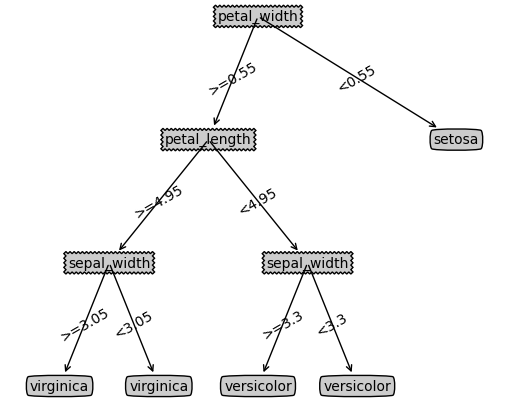

In [14]:
# Show Decision Tree 
tpl.createPlot(tr)

In [17]:
# define the classify fct for classify an item or row using the tree
def classify(tree, item):
    # If the current node is a leaf, return the class label
    if not isinstance(tree, dict):
        return tree  

    # Extract the feature and threshold from the current node
    feature, conditions = list(tree.items())[0]
    threshold = float(list(conditions.keys())[0].split('>=')[-1])

    # Determine which branch to follow based on threshold of the current feature
    if item[feature] >= threshold:
        branch = '>=' + str(threshold)
    else:
        branch = '<' + str(threshold)

    # Recursive call to classify with the subtree
    return classify(conditions[branch], item)

In [28]:
# classifaying the Testing values
predicted_datas = []
realData = []

for i in range(len(testingSet)) :
    data = {'sepal_length': testingSet.iloc[i][0],
            'sepal_width': testingSet.iloc[i][1],
            'petal_length': testingSet.iloc[i][2],
            'petal_width': testingSet.iloc[i][3]}
    
    predicted_datas.append(classify(tr, data))
    realData.append(testingSet.iloc[i][-1])
    
# print(predicted_datas)
# print(realData)
print("the model score => ", accuracy_score(realData, predicted_datas))

the model score =>  0.9736842105263158
